# Make Figures for Fast Formation Model vs. Experiment

12/14/2023

Use data from the UMBL2022FEB cells to compare model vs. experimental fast formation trends

Andrew Weng

In [32]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from src import plotter as plotter

%load_ext autoreload

plotter.initialize(plt)

target_dir = os.getcwd()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the Experimental Data

In [33]:
def fetch_file_list(cellid):

    target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'


    if cellid == 152064:
        file_arbin_list = [
        f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152064_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                        ]

        daq_channel = 'Key_CH1'

        hr_max = 20*24

    elif cellid == 152074: # BASELINE FORMATION (repeat 2)

        file_arbin_list = [
        f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv'
                        ]

        daq_channel = 'Key_CH0'

        hr_max = 20*24

    elif cellid == 152071: # FAST FORMATION

        file_arbin_list = [
            f'{target_dir_arbin}/UMBL2022FEB_CELL152071_FORM_TAP_2_P45C_5P0PSI_20220901_R1.csv',
            f'{target_dir_arbin}/UMBL2022FEB_CELL152071_FORMFAST_1_P45C_5P0PSI_20220902_R1.csv',
            f'{target_dir_arbin}/UMBL2022FEB_CELL152071_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
            f'{target_dir_arbin}/UMBL2022FEB_CELL152071_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
        ]

        daq_channel = 'Key_CH3'

        hr_max = 20*24

    return file_arbin_list, daq_channel, hr_max


In [34]:
def fetch_experimental_data(cellid):


    # To make the dQ/dV plot work, be sure to only select the FORM protocol without
    # including the aging file. Otherwise the time vector will be confused.
    file_indices_to_include = np.array([1,2])

    file_arbin_list, daq_channel, hr_max = fetch_file_list(cellid)


    # Load the Arbin Data
    df_arbin_list = []

    for file in np.array(file_arbin_list)[file_indices_to_include]:

        df = pd.read_csv(file)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
        df_arbin_list.append(df)

    df_arbin = pd.concat(df_arbin_list, axis=0)

    # Filter the Arbin Data
    qq = df_arbin['Charge Capacity (Ah)']
    tv = df_arbin['Timestamp'].astype(int)
    tv = (tv - np.min(tv)) / 1e9
    y_voltage = df_arbin['Potential (V)']
    y_current = df_arbin['Current (A)']

    y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN
    y_current.iloc[np.where(tv/3600 > hr_max)] = np.NaN

    # Load the Keyence data
    file_keyence = f'{target_dir}/data/raw/from-keyence/keyence_20220901_213928.csv'
    df_keyence = pd.read_csv(file_keyence)
    df_keyence['computer time'] = pd.to_datetime(df_keyence['computer time'], unit='s')
    df_keyence['computer time'] = df_keyence['computer time'].apply(lambda x : x.tz_localize(None))

    # Filter the Keyence data
    df_keyence = df_keyence.loc[(df_keyence['computer time'] > df_arbin['Timestamp'].iloc[0]) & \
                                (df_keyence['computer time'] < df_arbin['Timestamp'].iloc[-1])]
    y_strain = df_keyence[daq_channel] - df_keyence[daq_channel].iloc[0]
    y_strain[y_strain > 500] = np.NaN

    tt = df_keyence['computer time'].astype(int)
    tt = (tt - np.min(tt)) / 1e9

    y_strain.iloc[np.where(tt/3600 > hr_max)] = np.NaN

    out = dict()

    out['arbin_time'] = tv
    out['arbin_voltage'] = y_voltage
    out['arbin_current'] = y_current
    out['daq_time'] = tt
    out['daq_strain'] = y_strain

    return out


/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_13872/4258869760.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN
/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_13872/4258869760.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_current.iloc[np.where(tv/3600 > hr_max)] = np.NaN


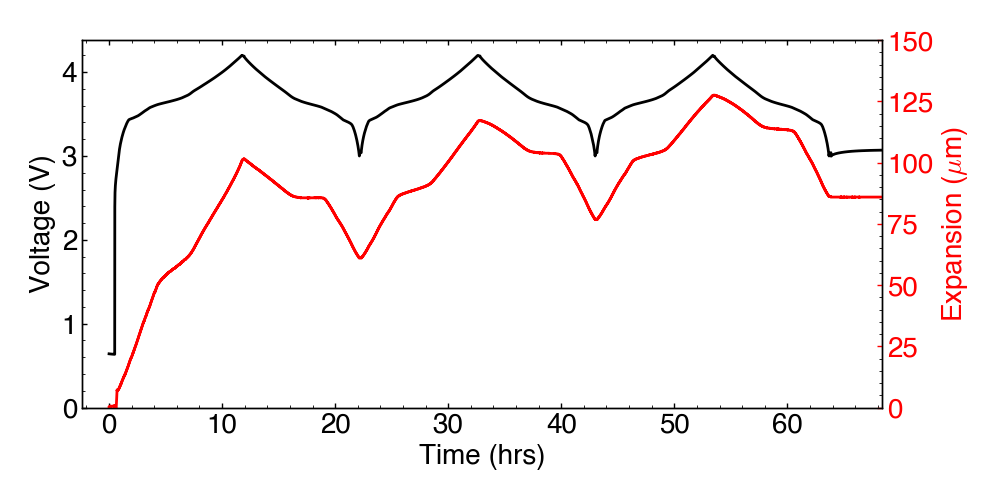

In [35]:
cellid = 152064
expt1 = fetch_experimental_data(cellid)

plt.figure(figsize=(10,5))

# The voltage plot
ax1 = plt.subplot()
ax1.plot(expt1['arbin_time']/3600, expt1['arbin_voltage'], color='k')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim(bottom=0)
ax1.grid(False)
ax1.set_xlim((-0.1 * 24, 2.85 * 24))

# The expansion plot
ax2 = ax1.twinx()
ax2.plot(expt1['daq_time']/3600, expt1['daq_strain'], color='r')
ax2.set_ylabel(r'Expansion ($\mu$m)')
ax2.tick_params(axis='y', colors='r')
ax2.yaxis.label.set_color('red')
ax2.set_ylim(bottom=0, top=150)
ax2.grid(False)

plt.savefig(f'outputs/figures/fig_strain_vs_voltage_cell{cellid}.png', dpi=300)


/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_13872/4258869760.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN
/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_13872/4258869760.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_current.iloc[np.where(tv/3600 > hr_max)] = np.NaN


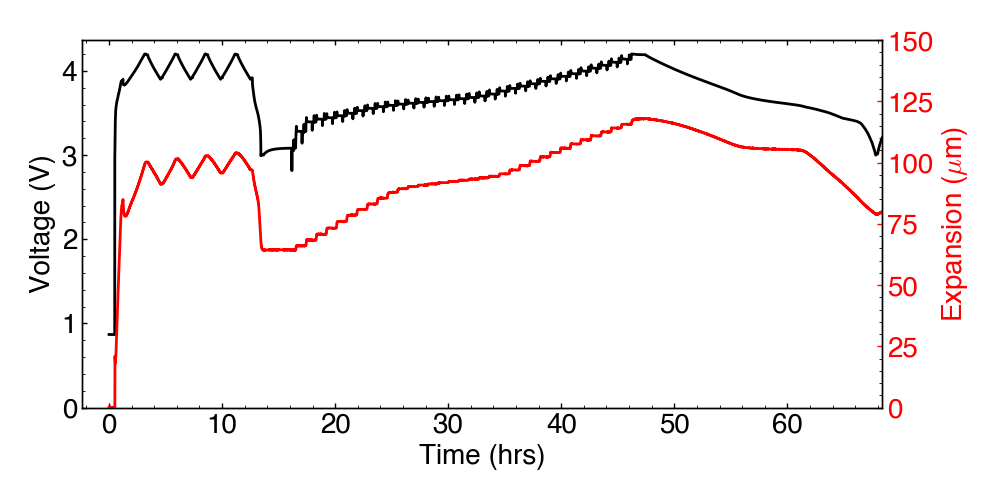

In [36]:
cellid = 152071
expt2 = fetch_experimental_data(cellid)

plt.figure(figsize=(10,5))

# The voltage plot
ax1 = plt.subplot()
ax1.plot(expt2['arbin_time']/3600, expt2['arbin_voltage'], color='k')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim(bottom=0)
ax1.grid(False)
ax1.set_xlim((-0.1 * 24, 2.85 * 24))

# The expansion plot
ax2 = ax1.twinx()
ax2.plot(expt2['daq_time']/3600, expt2['daq_strain'], color='r')
ax2.set_ylabel(r'Expansion ($\mu$m)')
ax2.tick_params(axis='y', colors='r')
ax2.yaxis.label.set_color('red')
ax2.set_ylim(bottom=0, top=150)
ax2.grid(False)

plt.savefig(f'outputs/figures/fig_strain_vs_voltage_cell{cellid}.png', dpi=300)


# Run the simulation: baseline formation

In [37]:
%autoreload
Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/default.yaml')
tag = cell.get_tag()

# sim = cellsim.Simulation(cell, 520*3600)
sim1 = cellsim.Simulation(cell, 26*20*3600)

# Formation
import time
sim1.run_rest(1, rest_time_hrs=0.5)
sim1.run_chg_cccv(2, 2.5/10, Icv, vmax)
sim1.run_dch_cccv(2, Idch, Idch, vmin)
sim1.run_chg_cccv(3, 2.5/10, Icv, vmax)
sim1.run_dch_cccv(3, Idch, Idch, vmin)
sim1.run_chg_cccv(4, 2.5/10, Icv, vmax)
sim1.run_dch_cccv(4, Idch, Idch, vmin)
sim1.run_rest(4, rest_time_hrs=6)

# RPT
sim1.run_chg_cccv(5, +2.5/30, +2.5/30, vmax) # Approximate HPPC Pulse Charge
sim1.run_dch_cccv(5, -2.5/20, Icv, vmin)
sim1.run_chg_cccv(6, +2.5/20, Icv, vmax)
sim1.run_rest(6, rest_time_hrs=14)
sim1.run_dch_cccv(7, -2.5/2, -2.5/2, vmin)
sim1.run_rest(7, rest_time_hrs=19)

# Aging
sim1.run_chg_cccv(8, 2.5/2, 2.5/2, vmax)
sim1.run_rest(8, rest_time_hrs=7*24)
sim1.run_dch_cccv(8, -2.5/20, -2.5/20, vmin)

# Cycling

for i in np.arange(9, 20):
    sim1.run_chg_cccv(i, 2.5, 2.5, vmax)
    sim1.run_dch_cccv(i, -2.5, -2.5, vmin)

df_sim1 = sim1.get_results()


Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc4: Rest for 6 hours...
Running Cyc5: Charge to 4.2V...
Running Cyc5: Discharge to 3.0V...
Running Cyc6: Charge to 4.2V...
Running Cyc6: Rest for 14 hours...
Running Cyc7: Discharge to 3.0V...
Running Cyc7: Rest for 19 hours...
Running Cyc8: Charge to 4.2V...
Running Cyc8: Rest for 168 hours...
Running Cyc8: Discharge to 3.0V...
Running Cyc9: Charge to 4.2V...
Running Cyc9: Discharge to 3.0V...
Running Cyc10: Charge to 4.2V...
Running Cyc10: Discharge to 3.0V...
Running Cyc11: Charge to 4.2V...
Running Cyc11: Discharge to 3.0V...
Running Cyc12: Charge to 4.2V...
Running Cyc12: Discharge to 3.0V...
Running Cyc13: Charge to 4.2V...
Running Cyc13: Discharge to 3.0V...
Running Cyc14: Charge to 4.2V...
Running Cyc14: Discharge to 3.0V...
Running Cy

/Users/aweng/code/formation-modeling/src/cellsim.py:900: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/{fig_name}.png',
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


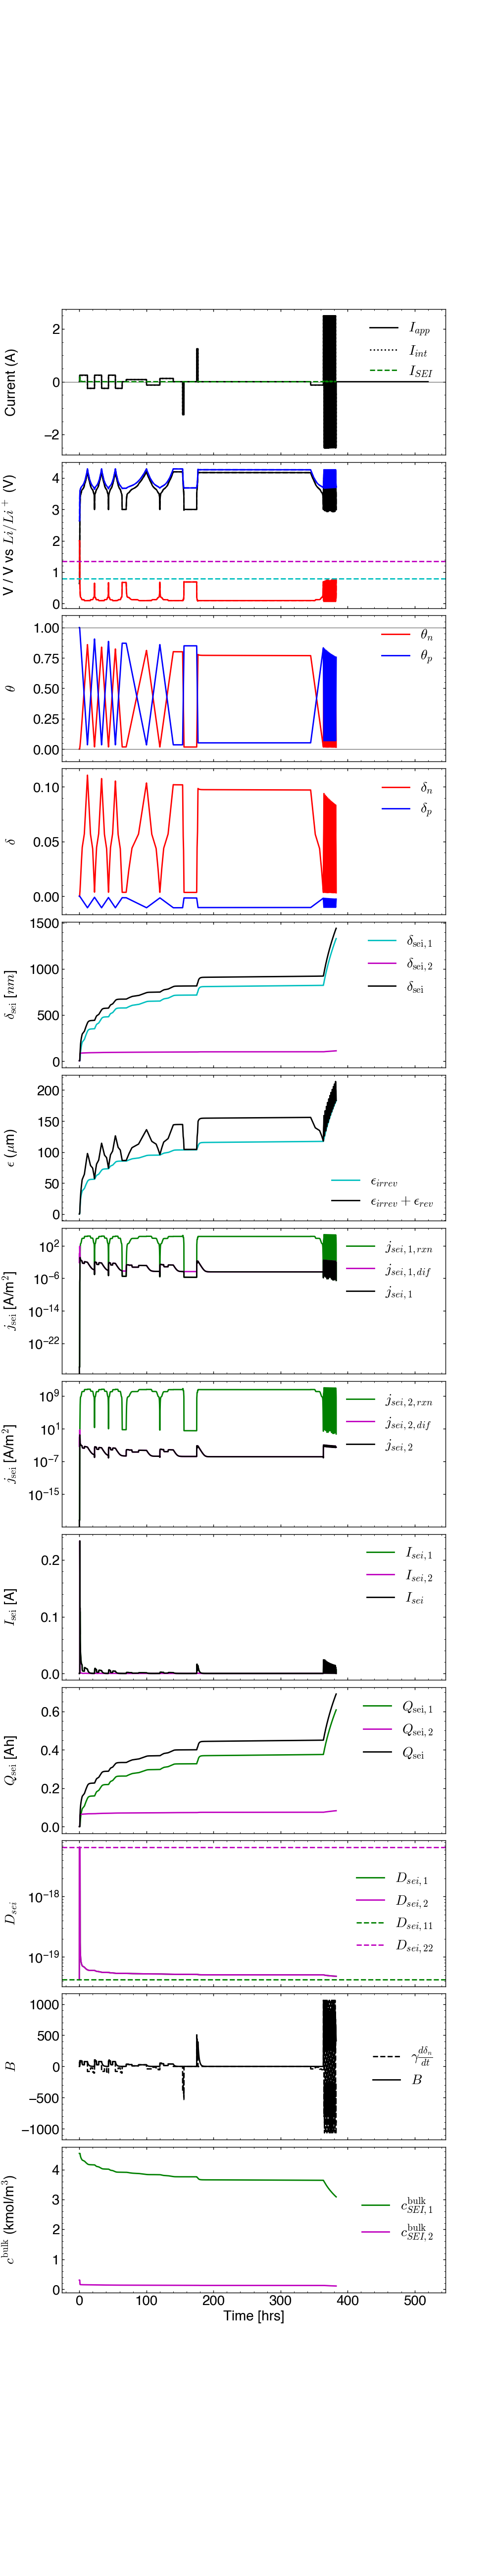

In [38]:

# %matplotlib widget
sim1.plot()


# Run the simulation: fast formation

In [39]:
%autoreload
Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/default.yaml')
tag = cell.get_tag()

# sim = cellsim.Simulation(cell, 520*3600)
sim2 = cellsim.Simulation(cell, 26*20*3600)

# Formation
import time
sim2.run_rest(1, rest_time_hrs=0.5)
sim2.run_chg_cccv(2, 2.5, 2.5, 3.9)
sim2.run_chg_cccv(2, 2.5/5, 2.5/100, 4.2)
sim2.run_dch_cccv(2, -2.5/5, 2.5/5, 3.9)
sim2.run_chg_cccv(3, 2.5/5, 2.5/100, 4.2)
sim2.run_dch_cccv(3, -2.5/5, 2.5/5, 3.9)
sim2.run_chg_cccv(4, 2.5/5, 2.5/100, 4.2)
sim2.run_dch_cccv(4, -2.5/5, 2.5/5, 3.9)
sim2.run_chg_cccv(5, 2.5/5, 2.5/100, 4.2)
sim2.run_dch_cccv(5, -2.5/5, 2.5/5, 3.9)
sim2.run_dch_cccv(5, -2.5/1, 2.5/1, 3.0)
sim2.run_rest(6, rest_time_hrs=3)

# RPT
sim2.run_chg_cccv(7, +2.5/30, +2.5/30, vmax) # Approximate HPPC Pulse Charge
sim2.run_dch_cccv(7, -2.5/20, Icv, vmin)
sim2.run_chg_cccv(8, +2.5/20, Icv, vmax)
sim2.run_rest(8, rest_time_hrs=14)
sim2.run_dch_cccv(9, -2.5/2, -2.5/2, vmin)
sim2.run_rest(9, rest_time_hrs=19)

# Aging
sim2.run_chg_cccv(10, 2.5/2, 2.5/2, vmax)
sim2.run_rest(10, rest_time_hrs=7*24)
sim2.run_dch_cccv(10, -2.5/20, -2.5/20, vmin)

# Cycling

for i in np.arange(11, 20):
    sim2.run_chg_cccv(i, 2.5, 2.5, vmax)
    sim2.run_dch_cccv(i, -2.5, -2.5, vmin)

df_sim2 = sim2.get_results()


Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 3.9V...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Discharge to 3.9V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.9V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.9V...
Running Cyc5: Charge to 4.2V...
Running Cyc5: Discharge to 3.9V...
Running Cyc5: Discharge to 3.0V...
Running Cyc6: Rest for 3 hours...
Running Cyc7: Charge to 4.2V...
Running Cyc7: Discharge to 3.0V...
Running Cyc8: Charge to 4.2V...
Running Cyc8: Rest for 14 hours...
Running Cyc9: Discharge to 3.0V...
Running Cyc9: Rest for 19 hours...
Running Cyc10: Charge to 4.2V...
Running Cyc10: Rest for 168 hours...
Running Cyc10: Discharge to 3.0V...
Running Cyc11: Charge to 4.2V...
Running Cyc11: Discharge to 3.0V...
Running Cyc12: Charge to 4.2V...
Running Cyc12: Discharge to 3.0V...
Running Cyc13: Charge to 4.2V...
Running Cyc13: Discharge to 3.0V...
Running Cyc14: Charge to 4.2V...
Running Cyc14: Discharge to 3.0V...
Running C

/Users/aweng/code/formation-modeling/src/cellsim.py:900: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/{fig_name}.png',
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


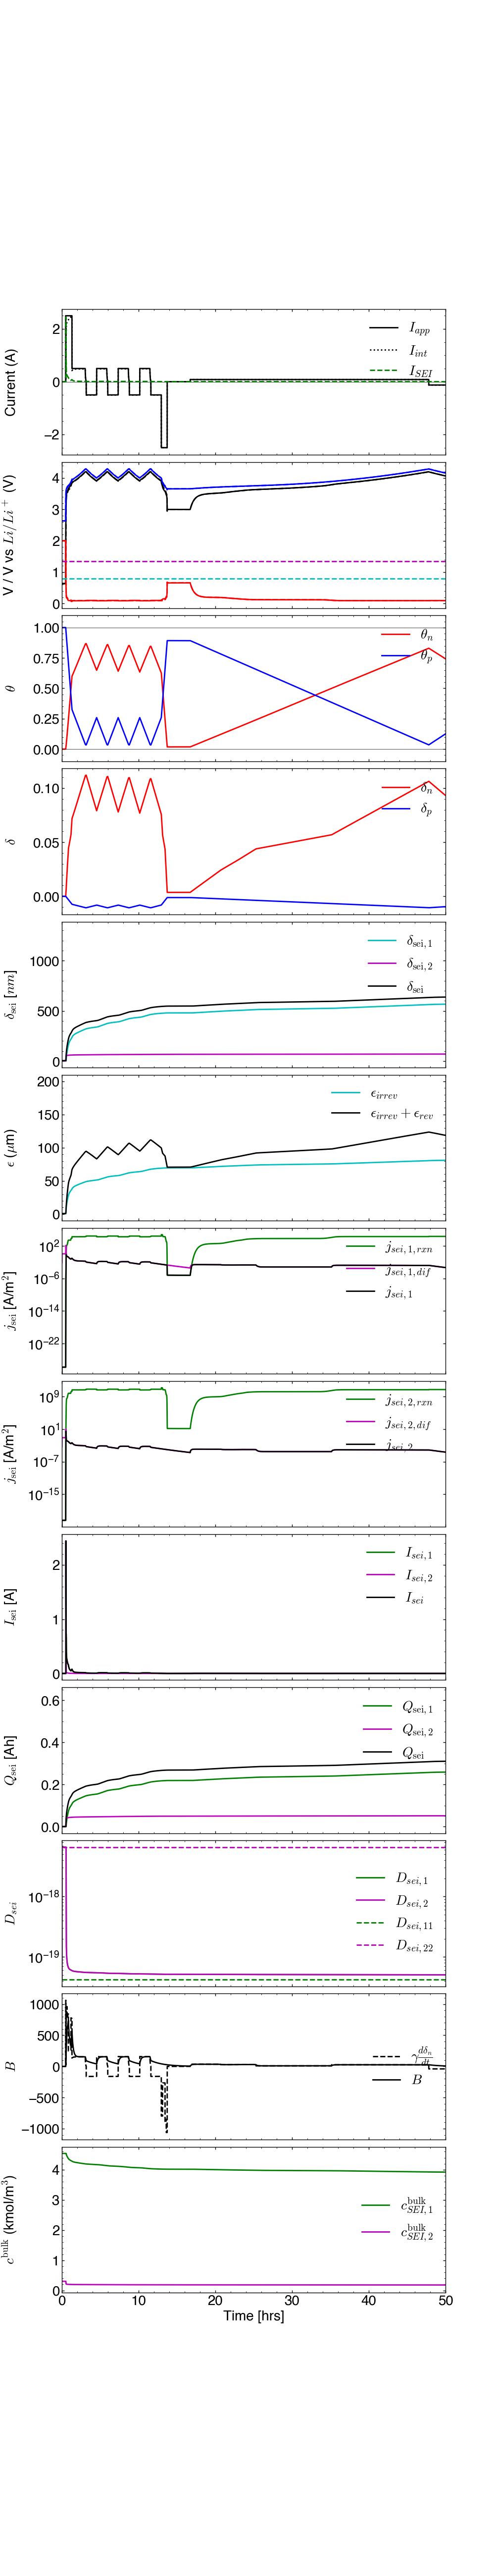

In [40]:
%matplotlib widget
sim2.plot(xlims=(0,50))


# Compare Voltages: Baseline Formation

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_13872/4056024130.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/fig_validation_{tag}.png', dpi=200)


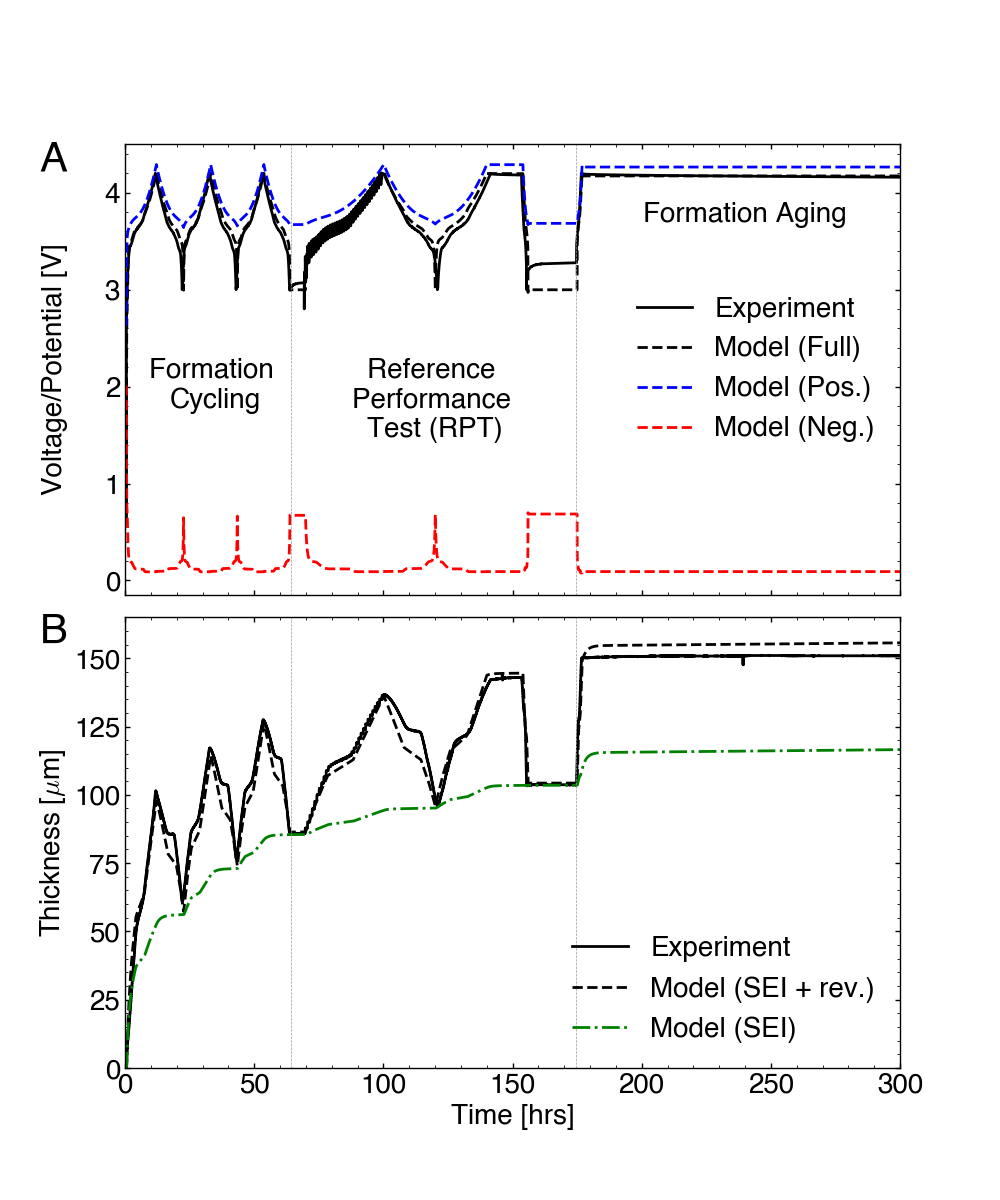

In [41]:
exp_sim = df_sim1['expansion_rev'] + df_sim1['expansion_irrev']
v_sim = df_sim1['vt']
t_sim = df_sim1['t']

gridspec = dict(hspace=0.05, height_ratios=[1,1])

fig, axs = plt.subplots(nrows=2, ncols=1,
                        figsize=(10,12),
                        gridspec_kw=gridspec,
                        sharex=True)

axs[0].grid(False)
axs[0].plot(expt1['arbin_time']/3600, expt1['arbin_voltage'], c='k', lw=2, label='Experiment')
axs[0].plot(t_sim/3600, df_sim1['vt'], c='k', ls='--', lw=2, label='Model (Full)')
axs[0].plot(t_sim/3600, df_sim1['ocv_p'] + df_sim1['eta_p'], c='b', ls='--', lw=2, label='Model (Pos.)')
axs[0].plot(t_sim/3600, df_sim1['ocv_n'] - df_sim1['eta_n'], c='r', ls='--', lw=2, label='Model (Neg.)')
axs[0].legend(loc='right', fontsize=20)
# axs[0].set_xlabel('Time (hrs)')
axs[0].set_ylabel('Voltage/Potential [V]')
axs[0].set_xlim((0, 300))

axs[1].grid(False)
axs[1].plot(expt1['daq_time']/3600, expt1['daq_strain'], c='k', lw=2, label='Experiment')
axs[1].plot(t_sim/3600, (df_sim1['expansion_rev'] + df_sim1['expansion_irrev'])*1e6, c='k', lw=2, ls='--', label='Model (SEI + rev.)')
axs[1].plot(t_sim/3600, (df_sim1['expansion_irrev'])*1e6, c='g', ls='-.', lw=2, label='Model (SEI)')
axs[1].legend(loc='lower right', fontsize=20)
axs[1].set_xlabel('Time [hrs]')
axs[1].set_ylabel('Thickness [$\mu$m]')
axs[1].set_ylim((0, 165))
axs[1].set_xlim((0, 300))

# Add guidelines
[ax.axvline(x=64.35, c=(0.6, 0.6, 0.6), linestyle='--', linewidth=0.5) for ax in axs]
[ax.axvline(x=174.5, c=(0.6, 0.6, 0.6), linestyle='--', linewidth=0.5) for ax in axs]

# Add text
axs[0].text(35, 2.3, 'Formation \nCycling', horizontalalignment='center', verticalalignment='top')
axs[0].text(120, 2.3, 'Reference \nPerformance \nTest (RPT)', horizontalalignment='center', verticalalignment='top')
axs[0].text(240, 3.7, 'Formation Aging', horizontalalignment='center')

# Add subplot identifers
axs[0].text(-0.11, 0.94, 'A', transform=axs[0].transAxes, fontsize=30, fontweight='bold')
axs[1].text(-0.11, 0.94, 'B', transform=axs[1].transAxes, fontsize=30, fontweight='bold')

fig.align_ylabels()

plt.savefig(f'outputs/figures/fig_validation_{tag}.png', dpi=200)


# Compare Voltages: Fast Formation

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_13872/199992933.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/fig_validation_{tag}.png', dpi=200)


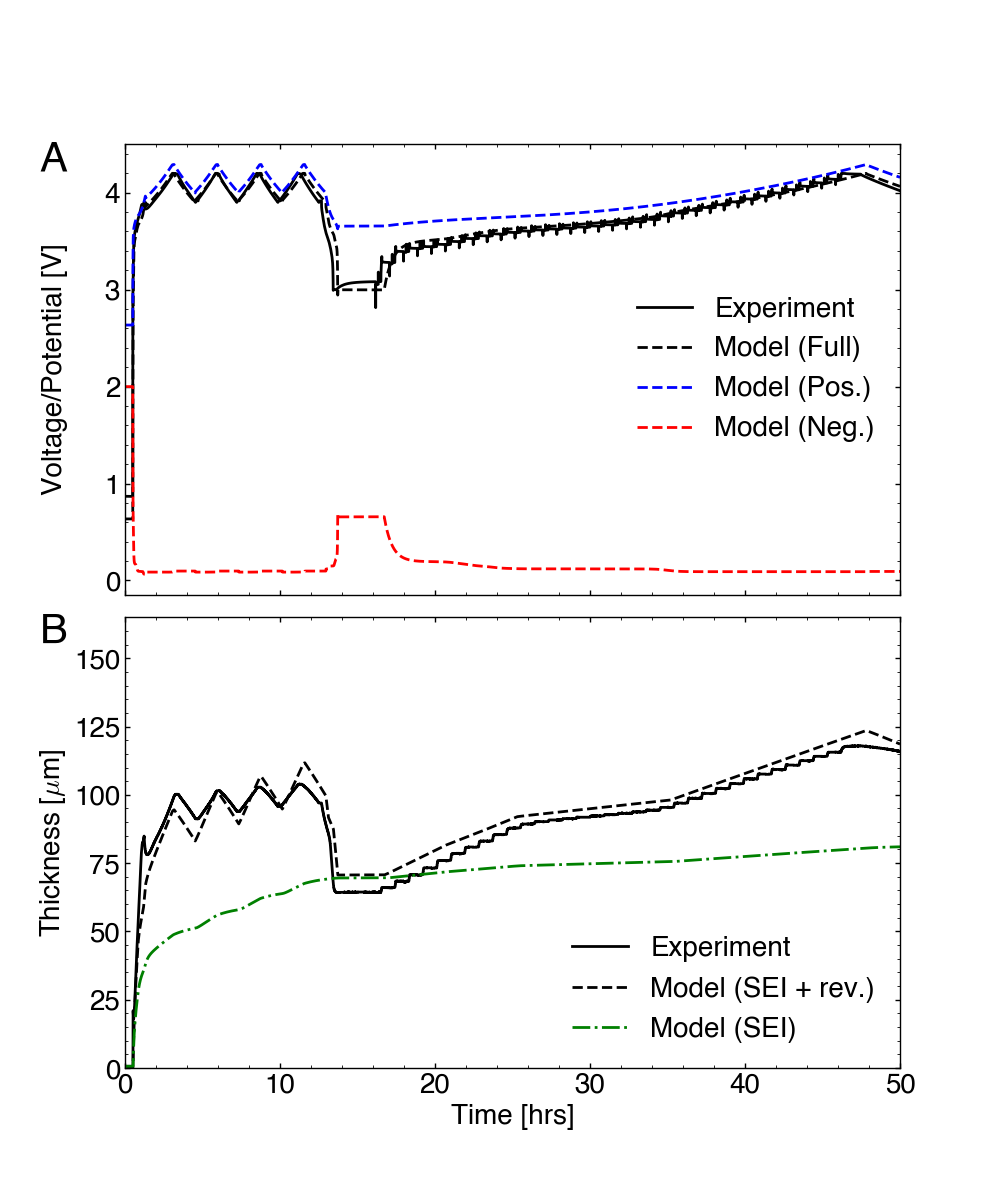

In [42]:
exp_sim = df_sim2['expansion_rev'] + df_sim2['expansion_irrev']
v_sim = df_sim2['vt']
t_sim = df_sim2['t']

XMAX = 50
gridspec = dict(hspace=0.05, height_ratios=[1,1])

fig, axs = plt.subplots(nrows=2, ncols=1,
                        figsize=(10,12),
                        gridspec_kw=gridspec,
                        sharex=True)

axs[0].grid(False)
axs[0].plot(expt2['arbin_time']/3600, expt2['arbin_voltage'], c='k', lw=2, label='Experiment')
axs[0].plot(t_sim/3600, df_sim2['vt'], c='k', ls='--', lw=2, label='Model (Full)')
axs[0].plot(t_sim/3600, df_sim2['ocv_p'] + df_sim2['eta_p'], c='b', ls='--', lw=2, label='Model (Pos.)')
axs[0].plot(t_sim/3600, df_sim2['ocv_n'] - df_sim2['eta_n'], c='r', ls='--', lw=2, label='Model (Neg.)')
axs[0].legend(loc='right', fontsize=20)
# axs[0].set_xlabel('Time (hrs)')
axs[0].set_ylabel('Voltage/Potential [V]')
axs[0].set_xlim((0, XMAX))

axs[1].grid(False)
axs[1].plot(expt2['daq_time']/3600, expt2['daq_strain'], c='k', lw=2, label='Experiment')
axs[1].plot(t_sim/3600, (df_sim2['expansion_rev'] + df_sim2['expansion_irrev'])*1e6, c='k', lw=2, ls='--', label='Model (SEI + rev.)')
axs[1].plot(t_sim/3600, (df_sim2['expansion_irrev'])*1e6, c='g', ls='-.', lw=2, label='Model (SEI)')
axs[1].legend(loc='lower right', fontsize=20)
axs[1].set_xlabel('Time [hrs]')
axs[1].set_ylabel('Thickness [$\mu$m]')
axs[1].set_ylim((0, 165))
axs[1].set_xlim((0, XMAX))

# Add guidelines
[ax.axvline(x=64.35, c=(0.6, 0.6, 0.6), linestyle='--', linewidth=0.5) for ax in axs]
[ax.axvline(x=174.5, c=(0.6, 0.6, 0.6), linestyle='--', linewidth=0.5) for ax in axs]

# Add text
# axs[0].text(35, 2.3, 'Formation \nCycling', horizontalalignment='center', verticalalignment='top')
# axs[0].text(120, 2.3, 'Reference \nPerformance \nTest (RPT)', horizontalalignment='center', verticalalignment='top')
# axs[0].text(240, 3.7, 'Formation Aging', horizontalalignment='center')

# Add subplot identifers
axs[0].text(-0.11, 0.94, 'A', transform=axs[0].transAxes, fontsize=30, fontweight='bold')
axs[1].text(-0.11, 0.94, 'B', transform=axs[1].transAxes, fontsize=30, fontweight='bold')

fig.align_ylabels()

plt.savefig(f'outputs/figures/fig_validation_{tag}.png', dpi=200)
